In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
# Truth Model
def a(t, w): # m/s^2
    return(10*np.sin(w*t))

def v(t, a, w, v_0): # m/s
    v = v_0 + (a/w)-(a/w)*np.cos(w*t)
    return(v)

def p(t, a, w, v_0, p_0):
    p = p_0 + (v_0 + (a/w))*t - (a/w**2)*np.sin(w*t)
    return(p)

# Accelerometer Model
def a_c(a, b, w):
    return(a + b + w)

def v_c(dt, v_c_0, a_c_0):
    return(v_c_0 + a_c_0 * dt)

def p_c(dt, p_c_0, v_c_0, a_c_0):
    return(p_c_0 + v_c_0*dt + a_c_0 * (dt**2)/2)


[ 0.04524637  0.01390689  0.15267098 ...  0.09139992 -0.03000561
 -0.17622618]
[0.53731517 0.        ] [ 0.         -0.11922744]


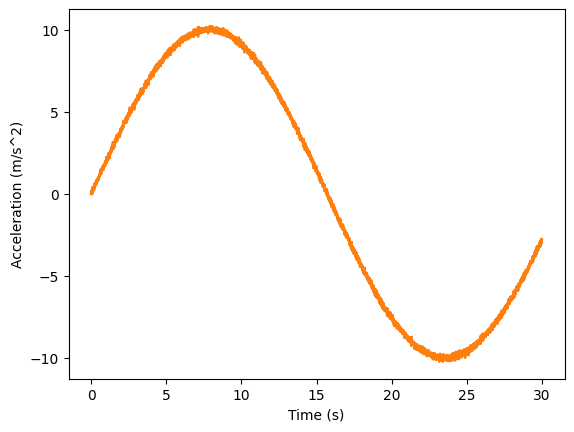

In [52]:
w = 0.2 # rad/s
sample_rate = 200.0 # Hz
dt = 1/sample_rate
num_samples = int(30/dt) + 1
V = 0.0004 # (m/s^2)^2

b_a = np.random.normal(0, np.sqrt(0.01), num_samples)
omega = np.random.normal(0, np.sqrt(V), num_samples)

v_0 = np.random.normal(100, np.sqrt(1))
p_0 = np.random.normal(0, np.sqrt(10))

[n1i, n2i] = np.random.normal(np.array([0, 0]).T, np.sqrt([[1, 0], [0, 0.04]]))
print(b_a)
print(n1i, n2i)

t = np.linspace(0, 30, num=int(30/dt) + 1, endpoint=True)
a_truth = a(t, w)
a_model = a_c(a_truth, b_a, omega)


plt.figure()
plt.plot(t, a_truth)
plt.plot(t, a_model)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.show()

# Kalman Filter Equations

In [ ]:
def x_k1(phi_k, x_k):
    return(phi_k @ x_k)

def M_k1(phi_k, P_k, gamma_k, W_k):
    return(phi_k @ P_k @ phi_k.T + gamma_k @ W_k @ gamma_k.T)

def x_k(x_k_prop, P_k, H_k, V_k, z_k):
    return(x_k_prop + P_k @ H_k.T @ V_k.I * (z_k - H_k@x_k_prop))

def P_k(M_k, H_k, V_k):
    return((M_k.I + H_k.T @ V_k.I @ H_k).I)

In [ ]:
phi = np.array([[1, dt, -dt**2/2],
                [0, 1, -dt],
                [0, 0, 1]])

gamma = np.array([[dt**2/2, dt, 0]]).T

[[ 1.00e+00  5.00e-03 -1.25e-05]
 [ 0.00e+00  1.00e+00 -5.00e-03]
 [ 0.00e+00  0.00e+00  1.00e+00]]
